# Wikimedia Case Study

At the beginning of January 2017, Wikimedia Deutschland ran a campaign to increase the number of Wikipedia editors. I was tasked with assessing the performance of the first week of the campaign and provide suggestions for improvement.

The data used in this notebook is freely available through the <a href="https://phabricator.wikimedia.org/P4339">Media Playcounts API</a>.

In [1]:
import requests as requests
import json as json
from pandas.io.json import json_normalize
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import seaborn as sns
from datetime import datetime
%matplotlib inline

______________________________________________________________________________________________________________________

# Assignment 1

*Task: Give a short introduction of how your skills can help to improve the next iteration of this campaign.*

### My answer:

As a data analyst, I can help highlight aspects of the campaign that are performing well and others that might require attention. This could be from a user perspective (e.g. Video 2 is receiving no clicks) or from a performance perspective (e.g. load time for Video 4 is five times longer than average). 

Below are some examples of the type of data I would need to make such suggestions:

- number of video play counts**\*** (as provided by the phabricator API) over time 
- time a user spends on a page
- number of page views over time
- number of pages a user visited and in what order - this would allow me to perform cohort analysis and identify where users are dropping out for example,
- position of the videos on the page - i.e. is a video located below the fold
- information regarding other campaigns or events that might be influencing the data

**\*** What do we mean exactly by *count* or *play count*?  I.e. does it mean that a user watched the video from start to finish or does watching a few seconds at the start also count? A precise definition of this quantity can help us understand whether or not we can use it a measure for a video's quality for example.

______________________________________________________________________________________________________________________

# Assigment 2

*Task: In particular, how could one measure success of the campaign and what would need to be considered
when using the metric you propose for that? Keep in mind that we theoretically can track everything
which is possible by both law and technology, but that we also take care of collecting the minimum
amount of data needed, especially concerning user identity/ user privacy.*

### My answer:

In my view, a successful campaign should lead to a steady increase in contributions **and** contributors over time. So possible metrics include the change in number of contributors (=editors) week on week (or day on day) and the change in number of edits (=contributions). Let's compute these metrics using an example dataset defined below.

In [2]:
data = pd.DataFrame({'Week': [1, 2, 3], 'Number_of_edits': [50, 55, 70], 'Number_of_active_editors': [100, 110, 115]})

In [3]:
data['change_in_edits'] = round(data.Number_of_edits.diff() / data.Number_of_edits.shift(1), 2)
data['change_in_active_editors'] = round(data.Number_of_active_editors.diff() / data.Number_of_active_editors.shift(1), 2)

In [4]:
data

,Number_of_active_editors,Number_of_edits,Week,change_in_edits,change_in_active_editors
0,100,50,1,NaN,NaN
1,110,55,2,0.10,0.10
2,115,70,3,0.27,0.05


However, we can go a step further: we can combine both `change_in_edits` and `change_in_editors` into a single metric. Taking inspiration from the <a href="https://en.wikipedia.org/wiki/F1_score">F1-score</a> which seeks to balance `precision` and `recall`, I devise the following metric:

In [5]:
def success_metric(change_in_edits, change_in_active_editors):
    return round(2 * (change_in_edits * change_in_active_editors) / (change_in_edits + change_in_active_editors), 2)

In [6]:
data['success_measure'] = data.apply(lambda x: success_metric(x['change_in_edits'], x['change_in_active_editors']),
                                     axis=1)

In [7]:
data

,Number_of_active_editors,Number_of_edits,Week,change_in_edits,change_in_active_editors,success_measure
0,100,50,1,NaN,NaN,NaN
1,110,55,2,0.10,0.10,0.10
2,115,70,3,0.27,0.05,0.08


So now we have a way a global metric to assess the performance of the campaign over time. In the example illustrated above, Week 2 was slightly more successful than Week 3 (0.10 > 0.08)

______________________________________________________________________________________________________________________

# Assignment 3

In [8]:
import requests as requests
import json as json
from pandas.io.json import json_normalize
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import seaborn as sns
from datetime import datetime
%matplotlib inline

## Functions and constants

In [9]:
api_base_url = 'https://tools.wmflabs.org/mediaplaycounts/api/1/FilePlaycount/'

In [10]:
start_date = '20161230'  # picking a date a couple days before the campaign
end_date = '20170214'  # today

In [11]:
video_list = [
    "ADA-Video_Mach_mit_bei_Wikipedia.webm",
    "Erkl%C3%A4rvideo_Wikipedia-Netzwerk.webm",
    "Erkl%C3%A4rvideo_Wikipedia-Quellen.webm",
    "Erkl%C3%A4rvideo_Wikipedia-Rollen.webm",
    "Machmit_Tutorials_Teaser.webm",
    "Tutorial_1_Benutzerseite_erstellen.webm",
    "Tutorial_2_Diskussionsseiten.webm",
    "Tutorial_3_Arbeiten_im_Visual_Editor.webm",
    "Tutorial_04_Artikel_verbessern.webm",
    "Tutorial_5_Bilder_in_der_Wikipedia.webm",
    "Tutorial_6_Artikel_verfassen.webm"]

In [12]:
def video_counts(filename, start_date=start_date, end_date=None):
    """Retrieve counts for a video."""
    if end_date is None:
        q = api_base_url + 'date/' + filename + '/' + start_date
    else: 
        q = api_base_url + 'date_range/' + filename + '/' + start_date + '/' + end_date
    # call the api:
    r = requests.get(q)
    
    # parse json:
    return json.loads(r.text)

In [13]:
def json_to_df(json_obj):
    """Convert json object to a pandas DataFrame."""
    vc_df = json_normalize(json_obj['details'])
    vc_df.date = pd.to_datetime(vc_df.date)
    # rename columns and return:
    return vc_df.rename(columns={'count': 'video_count'})

In [14]:
def plot_counts(ax, counts, short_date=False):
    """Plot playcounts per day."""
    rects = ax.bar(range(7), counts, width=0.5)

    # formatting x-axis:
    date_range = pd.date_range(start=jan_1, end=jan_7)
    
    if short_date:
        date_range = [x.strftime("%d %b") for x in date_range]
    else:
        date_range = [x.strftime("%a %d %b %y") for x in date_range]
    
    ax.set_xticks(np.arange(0.4, 7.4, 1))
    ax.set_xlim(-0.5, 7)
    ax.set_xticklabels(date_range)
    ax.set_ylabel('Number of play counts')
    
    return rects

In [15]:
def autolabel(rects):
    """Attach a text label above each bar displaying its height.
    
    Example taken from: http://matplotlib.org/examples/api/barchart_demo.html
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

## Analysis

In [16]:
vc_dfs = []
for filename in video_list:
    vc = video_counts(filename, start_date, end_date)
    vc_dfs.append(json_to_df(vc))

In [17]:
vc_dfs = pd.concat(vc_dfs)
vc_dfs.set_index('date', inplace=True)

### 1. Viewing total counts

In [18]:
jan_1, jan_7 = datetime(2017, 1, 1), datetime(2017, 1, 7)  # only interested in the first week of January

In [19]:
tot_counts = vc_dfs.reset_index().groupby('date').sum()[jan_1:jan_7]

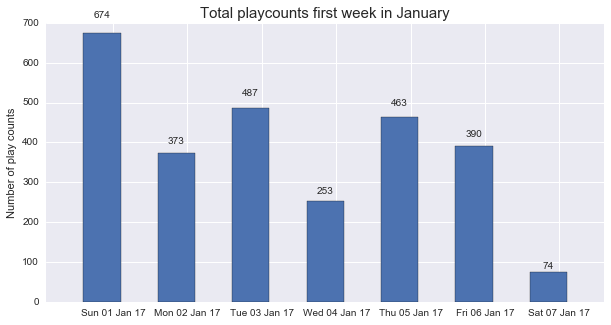

In [20]:
fig, ax = pl.subplots(figsize=(10, 5))
rects = plot_counts(ax, tot_counts.video_count)
pl.title('Total playcounts first week in January', size=15)
autolabel(rects)
pl.show()

### 2. Viewing counts for specific videos

Not all videos appear on the same page so I've grouped them into 3 categories so that wherever possible we are comparing like for like. 

**Category 1:** Videos that appear on the <a href="https://de.wikipedia.org/wiki/Wikipedia:Wikimedia_Deutschland/Mach_mit">Mach mit</a> page: the `"ADA-Video_Mach_mit_bei_Wikipedia.webm"` video only;

**Category 2:** Videos that appear on both the <a href="https://de.wikipedia.org/wiki/Wikipedia:Wikimedia_Deutschland/Mach_mit/Neuer_Benutzer">Mach mit/Neuer Benutzer</a> and <a href="https://de.wikipedia.org/wiki/Wikipedia:Wikimedia_Deutschland/Mach_mit/Benutzer">Mach mit/Benutzer</a>: the `"Machmit_Tutorials_Teaser"` and the `"Erklärung"` videos;

**Category 3:** Videos that appear only on the <a href="https://de.wikipedia.org/wiki/Wikipedia:Wikimedia_Deutschland/Mach_mit/Benutzer">Mach mit/Benutzer</a> page: the `"Tutorials"` videos.

#### 1. Mach mit

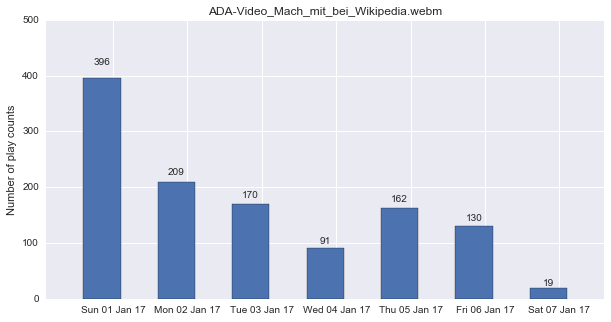

In [21]:
filename = "ADA-Video_Mach_mit_bei_Wikipedia.webm"
tmp = vc_dfs[vc_dfs.filename == filename][jan_1:jan_7]
fig, ax = pl.subplots(figsize=(10, 5))
rects = plot_counts(ax, tmp.video_count)
ax.set_title(filename)
pl.ylim(0, 500)
autolabel(rects)
pl.show()

#### 2. Mach mit/Neuer Benutzer and Mach mit/Benutzer:

In [22]:
filenames = [fname for fname in vc_dfs.filename.unique() if ("Erkl" in fname) or ("Tutorials" in fname)]

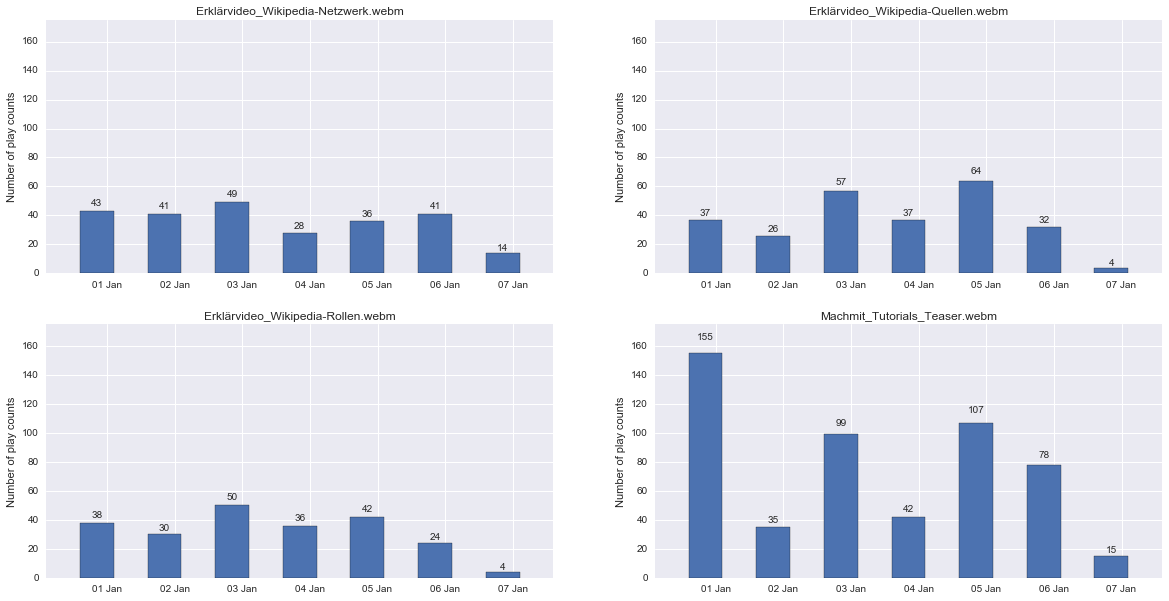

In [23]:
pl.figure(figsize=(20, 10))
pl.tight_layout
p = 1
for filename in filenames:
    tmp = vc_dfs[vc_dfs.filename == filename][jan_1:jan_7]
    # add subplot:
    ax = pl.subplot(2, 2, p)
    rects = plot_counts(ax, tmp.video_count, short_date=True)
    pl.title(filename)
    pl.ylim(0, 175)
    autolabel(rects)
    p += 1

#### 3. Mach mit/Benutzer only:

In [24]:
filenames = [fname for fname in vc_dfs.filename.unique() if "Tutorial_" in fname]

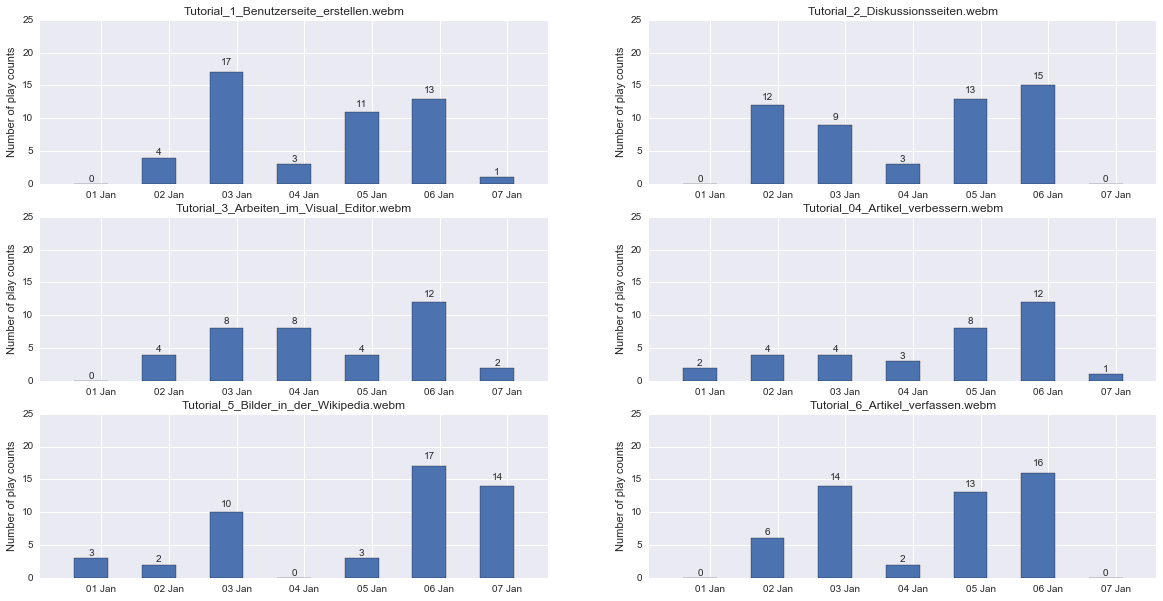

In [25]:
pl.figure(figsize=(20, 10))
pl.tight_layout
p = 1
for filename in filenames:
    tmp = vc_dfs[vc_dfs.filename == filename][jan_1:jan_7]
    # add subplot:
    ax = pl.subplot(3, 2, p)
    rects = plot_counts(ax, tmp.video_count, short_date=True)
    pl.title(filename)
    pl.ylim(0, 25)
    autolabel(rects)
    p += 1

### A few suggestions for Bob:

- The main video `"ADA-Video_Mach_mit"` appears to be receiving a healthy number of plays, decreasing from Sunday 1st Jan to Wednesday 4th Jan then bouncing back on Thursday 5th Jan and Friday 6th Jan. If I had more data at my disposal I would check if this large drop in activity on Wednesday compared to Tuesday is a regular phenomenon or could it be that the banner ad was shown to a smaller audience on that day?


- I noticed that the video called `"Mach mit Tutorials Teaser"` received a relatively high number of views with a mean daily count of 78 but this is not reflected in the play counts for the `"Tutorials"` themselves. Is there a problem with the Teaser? Are the Tutorials even necessary?


- In fact, the `"Tutorials"` videos 1-6 received a very low amount of views with a daily average of 6.5 play counts per video over the course of the first week compared to the other videos, so they are clearly not performing that well. I would ask the rest of the team to investigate why this is the case. Is it to do with the position of the videos on the page for example? Would it help to rename them? Until the videos start receiving more plays it is difficult to compare them to each other given the low number of play counts.


- 3 of the Tutorials received no views on the first day of the campaign, was this due to a technical problem? 